In [ ]:
# #To be used on cloud platforms

# ! python -c "import pykeen" || pip install pykeen
# ! python -c "import scprep" || pip install scprep

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt
import networkx, scprep, magic, torch, pykeen
import rpy2, rpy2.situation

In [2]:
print(os.getcwd())
data_dir = f"{os.getcwd()}/data"
kge_dir = f"{os.getcwd()}/KGEs"

# print(data_dir, kge_dir)

# #Test if below is amy different from above in Farnam
# if "ferran" not in os.getcwd():
#     data_dir = "/home/fc489/project/yaleCollab/data"
#     kge_dir = "/home/fc489/project/yaleCollab/KGEs"
# #Confirmed that it's the same (jsut different path string due to symlinks)
# print(data_dir, kge_dir)

/gpfs/ysm/home/fc489/yaleCollab


**DEPRECATION WARNING**

This notebook represents the first effort towards creating a KGE of the 
CellChat and STRING DBS. 

It will act as the stepping stone for a second notebook where we will try to 
incorporate our own scRNA-seq datasets. Code in this notebook will be used to 
build functions for future notebooks, and the repository structure will also be 
modified, relegating this current notebook to a non-functional state.

# Explore PyKEEN and default data

In [ ]:
# import pandas as pd

# from pykeen.triples import TriplesFactory
# from pykeen.pipeline import pipeline
# from pykeen.datasets.nations import NATIONS_TRAIN_PATH

# tf = TriplesFactory.from_path(NATIONS_TRAIN_PATH)

# print(NATIONS_TRAIN_PATH)
# print(tf)

# # training, testing = tf.split()

# # result = pipeline(

# #     training=training,

# #     testing=testing,

# #     model='TransE',

# #     epochs=5,  # short epochs for testing - you should go higher

# # )

# # result.save_to_directory('doctests/test_unstratified_transe')

In [ ]:
# pd.read_csv('/usr/local/lib/python3.9/site-packages/pykeen/datasets/nations/train.txt', sep='\t')

Format data for PYKEEN is in the form of a TSV file with the (h,r,t) format.
THis means that the edges are indeed directed.

WEe can now take either one of two approaches:

- Use STRING database ass a proof of concept. All of these interactions will be considered as @signsallnig interactions. KG will end up having 2 types of edges: those from strign and those from cellchat
- Proper approach with the Functional INteraction network from reactome. Here interaction edges can be of different types, and string comprehension will have to be built to decode the direction column into individual triplets with the (h,r,t) format

## RPY2 cheatsheet

Using R from Python

In [ ]:
# import rpy2
# import rpy2.situation
# for row in rpy2.situation.iter_info(): # Print Rpy2 info
#     print(row)

# from rpy2.robjects.packages import importr
# base = importr("base")
# here = importr("here")

# if here.here()[0] != base_dir:
#     raise ValueError

In [ ]:
# from rpy2.robjects.packages import importr
# base = importr("base")
# here = importr("here")

# INTepi21 = base.readRDS(here.here("CRCTME_story/Integration_CRCTME-Aug21/RData",
# "INTepi21_filt_2022.rds"))
# INTepi21

Load R chunks

In [ ]:
# %load_ext rpy2.ipython

In [ ]:
# %%R
# R.version.string

In [ ]:
# %%R -i INTepi21
# library(base)
# library(tidyverse)
# library(Seurat)
# library(here)

# INTepi21

# STRING + CellchatDB KGE

In [3]:
for row in rpy2.situation.iter_info(): # Print Rpy2 info
    print(row)

from rpy2.robjects.packages import importr
base = importr("base")
here = importr("here")

if here.here()[0] != os.getcwd():
    raise ValueError

from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

rpy2 version:
3.5.1
Python version:
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:58:50) 
[GCC 10.3.0]
Looking for R's HOME:
    Environment variable R_HOME: None
    Calling `R RHOME`: /gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:

R version:
    In the PATH: R version 4.1.3 (2022-03-10) -- "One Push-Up"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib/R/lib', '/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/collab/lib']
  extra_compile_args:
  []
  extra_link_args:
  ['

Download cellchat DB with the following:

`wget https://github.com/sqjin/CellChat/raw/master/data/CellChatDB.mouse.rda`

TO use in the cloud, ahve logic that looks for local file, if not present, try to download with ipynb cloud !bash notation and if it fails (for reasons or because user is local) just prompt to download from URL.

In [6]:
r["load"](f"{data_dir}/DBs/CellChatDB.mouse.rda")

ccDB_mouse = r["CellChatDB.mouse"]
ccDB_mouse[0]

<rpy2.robjects.vectors.DataFrame object at 0x2ac502422c40> [RTYPES.VECSXP]
R classes: ('data.frame',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  interaction_name: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502434100> [RTYPES.STRSXP]
R classes: ('character',)
['TGFB1_TG..., 'TGFB2_TG..., 'TGFB3_TG..., 'TGFB1_AC..., ..., 'ITGA4_IT..., 'ITGA9_IT..., 'ITGA4_IT..., 'VSIR_IGS...]
  pathway_name: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac5024341c0> [RTYPES.STRSXP]
R classes: ('character',)
['TGFb', 'TGFb', 'TGFb', 'TGFb', ..., 'VCAM', 'VCAM', 'VCAM', 'VISTA']
  ligand: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502434800> [RTYPES.STRSXP]
R classes: ('character',)
['Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfb1', ..., 'ITGA4_IT..., 'ITGA9_IT..., 'ITGA4_IT..., 'Vsir']
  receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502434b80> [RTYPES.STRSXP]
R classes: ('character',)
['TGFbR1_R2', 'TGFbR1_R2', 'TGFbR1_R2', 'ACVR1B_T..., ..., 'Vcam1', 'Vcam1', 'Vcam1', 'Igsf11']
...
  antagonist: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502434e40> [RTYPES.STRSXP]
R classes: ('character',)
['TGFb inh..., 'TGFb inh..., 'TGFb inh..., 'TGFb inh..., ..., '', '', '', '']
  co_A_receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502434e00> [RTYPES.STRSXP]
R classes: ('character',)
['KEGG: mm..., 'KEGG: mm..., 'KEGG: mm..., 'PMID: 27..., ..., 'KEGG: mm..., 'KEGG: mm..., 'KEGG: mm..., 'KEGG: mm...]
  co_I_receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac5024374c0> [RTYPES.STRSXP]
R classes: ('character',)
['Secreted..., 'Secreted..., 'Secreted..., 'Secreted..., ..., 'Cell-Cel..., 'Cell-Cel..., 'Cell-Cel..., 'Cell-Cel...]
  evidence: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502437800> [RTYPES.STRSXP]
R classes: ('character',)
['Tgfb1 - ..., 'Tgfb2  -..., 'Tgfb3  -..., 'Tgfb1  -..., ..., 'Vcam1 - ..., 'Vcam1 - ..., 'Vcam1 - ..., 'Vsir  - ...]

In [13]:
pandas2ri.rpy2py(r["CellChatDB.mouse"][0])

interaction_name pathway_name       ligand  \
TGFB1_TGFBR1_TGFBR2  TGFB1_TGFBR1_TGFBR2         TGFb        Tgfb1   
TGFB2_TGFBR1_TGFBR2  TGFB2_TGFBR1_TGFBR2         TGFb        Tgfb2   
TGFB3_TGFBR1_TGFBR2  TGFB3_TGFBR1_TGFBR2         TGFb        Tgfb3   
TGFB1_ACVR1B_TGFBR2  TGFB1_ACVR1B_TGFBR2         TGFb        Tgfb1   
TGFB1_ACVR1C_TGFBR2  TGFB1_ACVR1C_TGFBR2         TGFb        Tgfb1   
...                                  ...          ...          ...   
TIGIT_PVR                      TIGIT_PVR        TIGIT        Tigit   
ITGA4_ITGB1_VCAM1      ITGA4_ITGB1_VCAM1         VCAM  ITGA4_ITGB1   
ITGA9_ITGB1_VCAM1      ITGA9_ITGB1_VCAM1         VCAM  ITGA9_ITGB1   
ITGA4_ITGB7_VCAM1      ITGA4_ITGB7_VCAM1         VCAM  ITGA4_ITGB7   
VSIR_IGSF11                  VSIR_IGSF11        VISTA         Vsir   

                          receptor       agonist       antagonist  \
TGFB1_TGFBR1_TGFBR2      TGFbR1_R2  TGFb agonist  TGFb antagonist   
TGFB2_TGFBR1_TGFBR2      TGFbR1_R2  TGFb agonist  TGFb antagonist   
TGFB3_TGFBR1_TGFBR2      TGFbR1_R2  TGFb agonist  TGFb antagonist   
TGFB1_ACVR1B_TGFBR2  ACVR1B_TGFbR2  TGFb agonist  TGFb antagonist   
TGFB1_ACVR1C_TGFBR2  ACVR1C_TGFbR2  TGFb agonist  TGFb antagonist   
...                            ...           ...              ...   
TIGIT_PVR                      Pvr                                  
ITGA4_ITGB1_VCAM1            Vcam1                                  
ITGA9_ITGB1_VCAM1            Vcam1                                  
ITGA4_ITGB7_VCAM1            Vcam1                                  
VSIR_IGSF11                 Igsf11                                  

                    co_A_receptor             co_I_receptor        evidence  \
TGFB1_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB2_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB3_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB1_ACVR1B_TGFBR2                TGFb inhibition receptor  PMID: 27449815   
TGFB1_ACVR1C_TGFBR2                TGFb inhibition receptor  PMID: 27449815   
...                           ...                       ...             ...   
TIGIT_PVR                                                     PMID:24987108   
ITGA4_ITGB1_VCAM1                                            KEGG: mmu04514   
ITGA9_ITGB1_VCAM1                                            KEGG: mmu04514   
ITGA4_ITGB7_VCAM1                                            KEGG: mmu04514   
VSIR_IGSF11                                                  KEGG: mmu04514   

                             annotation        interaction_name_2  
TGFB1_TGFBR1_TGFBR2  Secreted Signaling   Tgfb1 - (Tgfbr1+Tgfbr2)  
TGFB2_TGFBR1_TGFBR2  Secreted Signaling  Tgfb2  - (Tgfbr1+Tgfbr2)  
TGFB3_TGFBR1_TGFBR2  Secreted Signaling  Tgfb3  - (Tgfbr1+Tgfbr2)  
TGFB1_ACVR1B_TGFBR2  Secreted Signaling  Tgfb1  - (Acvr1b+Tgfbr2)  
TGFB1_ACVR1C_TGFBR2  Secreted Signaling  Tgfb1  - (Acvr1c+Tgfbr2)  
...                                 ...                       ...  
TIGIT_PVR             Cell-Cell Contact              Tigit  - Pvr  
ITGA4_ITGB1_VCAM1     Cell-Cell Contact     Vcam1 - (Itga4+Itgb1)  
ITGA9_ITGB1_VCAM1     Cell-Cell Contact     Vcam1 - (Itga9+Itgb1)  
ITGA4_ITGB7_VCAM1     Cell-Cell Contact     Vcam1 - (Itga4+Itgb7)  
VSIR_IGSF11           Cell-Cell Contact            Vsir  - Igsf11  

[2019 rows x 11 columns]

In [10]:
ccDB_mouse[0]

<rpy2.robjects.vectors.DataFrame object at 0x2ac502419700> [RTYPES.VECSXP]
R classes: ('data.frame',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe...]
  interaction_name: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac50243d840> [RTYPES.STRSXP]
R classes: ('character',)
['TGFB1_TG..., 'TGFB2_TG..., 'TGFB3_TG..., 'TGFB1_AC..., ..., 'ITGA4_IT..., 'ITGA9_IT..., 'ITGA4_IT..., 'VSIR_IGS...]
  pathway_name: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac50243d880> [RTYPES.STRSXP]
R classes: ('character',)
['TGFb', 'TGFb', 'TGFb', 'TGFb', ..., 'VCAM', 'VCAM', 'VCAM', 'VISTA']
  ligand: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac50243d680> [RTYPES.STRSXP]
R classes: ('character',)
['Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfb1', ..., 'ITGA4_IT..., 'ITGA9_IT..., 'ITGA4_IT..., 'Vsir']
  receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac50243d080> [RTYPES.STRSXP]
R classes: ('character',)
['TGFbR1_R2', 'TGFbR1_R2', 'TGFbR1_R2', 'ACVR1B_T..., ..., 'Vcam1', 'Vcam1', 'Vcam1', 'Igsf11']
...
  antagonist: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502463780> [RTYPES.STRSXP]
R classes: ('character',)
['TGFb inh..., 'TGFb inh..., 'TGFb inh..., 'TGFb inh..., ..., '', '', '', '']
  co_A_receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502463540> [RTYPES.STRSXP]
R classes: ('character',)
['KEGG: mm..., 'KEGG: mm..., 'KEGG: mm..., 'PMID: 27..., ..., 'KEGG: mm..., 'KEGG: mm..., 'KEGG: mm..., 'KEGG: mm...]
  co_I_receptor: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502463bc0> [RTYPES.STRSXP]
R classes: ('character',)
['Secreted..., 'Secreted..., 'Secreted..., 'Secreted..., ..., 'Cell-Cel..., 'Cell-Cel..., 'Cell-Cel..., 'Cell-Cel...]
  evidence: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x2ac502463b40> [RTYPES.STRSXP]
R classes: ('character',)
['Tgfb1 - ..., 'Tgfb2  -..., 'Tgfb3  -..., 'Tgfb1  -..., ..., 'Vcam1 - ..., 'Vcam1 - ..., 'Vcam1 - ..., 'Vsir  - ...]

In [ ]:
ccDB_mouse[3]

Symbol                                               Name  \
MGI:87853           a                                          nonagouti   
MGI:87854         Pzp                    PZP, alpha-2-macroglobulin like   
MGI:87859        Abl1     c-abl oncogene 1, non-receptor tyrosine kinase   
MGI:87860        Abl2  v-abl Abelson murine leukemia viral oncogene 2...   
MGI:87862    Scgb1b27                secretoglobin, family 1B, member 27   
...               ...                                                ...   
MGI:1913728      Cd99                                       CD99 antigen   
MGI:96876        Klra      killer cell lectin-like receptor, subfamily A   
MGI:1891386    Ccl21c         chemokine (C-C motif) ligand 21C (leucine)   
MGI:107670       Ifna                                   interferon alpha   
MGI:109477     Raet1a            retinoic acid early transcript 1, alpha   

             EntrezGene.ID     Ensembl.Gene.ID HomoloGene.ID     HGNC.ID  
MGI:87853            50518  ENSMUSG00000027596          1264    HGNC:745  
MGI:87854            11287  ENSMUSG00000030359        104112        null  
MGI:87859            11350  ENSMUSG00000026842          3783     HGNC:76  
MGI:87860            11352  ENSMUSG00000026596          5278     HGNC:77  
MGI:87862            11354  ENSMUSG00000066583        114479        null  
...                    ...                 ...           ...         ...  
MGI:1913728         673094                             48107   HGNC:7082  
MGI:96876            17055                                     HGNC:6372  
MGI:1891386         111654                                    HGNC:10620  
MGI:107670            4663                                                
MGI:109477           19368                                                

[45551 rows x 6 columns]

In [ ]:
#Print ligands and receptors
dCellChat = ccDB_mouse[0]

ligands = [str(x.split(" - ")[0].strip()) for x in dCellChat["interaction_name_2"]]

receptors = [x.split(" - ")[1][1:-1].strip().split("+") if "+" in x 
                else str(x.split(" - ")[1].strip()) 
            for x in dCellChat["interaction_name_2"]]
#Nested list for coreceptors, otherwise store as string

dCellChat["ligand"] = ligands
dCellChat["receptor"] = receptors

dCellChat

interaction_name pathway_name ligand  \
TGFB1_TGFBR1_TGFBR2  TGFB1_TGFBR1_TGFBR2         TGFb  Tgfb1   
TGFB2_TGFBR1_TGFBR2  TGFB2_TGFBR1_TGFBR2         TGFb  Tgfb2   
TGFB3_TGFBR1_TGFBR2  TGFB3_TGFBR1_TGFBR2         TGFb  Tgfb3   
TGFB1_ACVR1B_TGFBR2  TGFB1_ACVR1B_TGFBR2         TGFb  Tgfb1   
TGFB1_ACVR1C_TGFBR2  TGFB1_ACVR1C_TGFBR2         TGFb  Tgfb1   
...                                  ...          ...    ...   
TIGIT_PVR                      TIGIT_PVR        TIGIT  Tigit   
ITGA4_ITGB1_VCAM1      ITGA4_ITGB1_VCAM1         VCAM  Vcam1   
ITGA9_ITGB1_VCAM1      ITGA9_ITGB1_VCAM1         VCAM  Vcam1   
ITGA4_ITGB7_VCAM1      ITGA4_ITGB7_VCAM1         VCAM  Vcam1   
VSIR_IGSF11                  VSIR_IGSF11        VISTA   Vsir   

                             receptor       agonist       antagonist  \
TGFB1_TGFBR1_TGFBR2  [Tgfbr1, Tgfbr2]  TGFb agonist  TGFb antagonist   
TGFB2_TGFBR1_TGFBR2  [Tgfbr1, Tgfbr2]  TGFb agonist  TGFb antagonist   
TGFB3_TGFBR1_TGFBR2  [Tgfbr1, Tgfbr2]  TGFb agonist  TGFb antagonist   
TGFB1_ACVR1B_TGFBR2  [Acvr1b, Tgfbr2]  TGFb agonist  TGFb antagonist   
TGFB1_ACVR1C_TGFBR2  [Acvr1c, Tgfbr2]  TGFb agonist  TGFb antagonist   
...                               ...           ...              ...   
TIGIT_PVR                         Pvr                                  
ITGA4_ITGB1_VCAM1      [Itga4, Itgb1]                                  
ITGA9_ITGB1_VCAM1      [Itga9, Itgb1]                                  
ITGA4_ITGB7_VCAM1      [Itga4, Itgb7]                                  
VSIR_IGSF11                    Igsf11                                  

                    co_A_receptor             co_I_receptor        evidence  \
TGFB1_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB2_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB3_TGFBR1_TGFBR2                TGFb inhibition receptor  KEGG: mmu04350   
TGFB1_ACVR1B_TGFBR2                TGFb inhibition receptor  PMID: 27449815   
TGFB1_ACVR1C_TGFBR2                TGFb inhibition receptor  PMID: 27449815   
...                           ...                       ...             ...   
TIGIT_PVR                                                     PMID:24987108   
ITGA4_ITGB1_VCAM1                                            KEGG: mmu04514   
ITGA9_ITGB1_VCAM1                                            KEGG: mmu04514   
ITGA4_ITGB7_VCAM1                                            KEGG: mmu04514   
VSIR_IGSF11                                                  KEGG: mmu04514   

                             annotation        interaction_name_2  
TGFB1_TGFBR1_TGFBR2  Secreted Signaling   Tgfb1 - (Tgfbr1+Tgfbr2)  
TGFB2_TGFBR1_TGFBR2  Secreted Signaling  Tgfb2  - (Tgfbr1+Tgfbr2)  
TGFB3_TGFBR1_TGFBR2  Secreted Signaling  Tgfb3  - (Tgfbr1+Tgfbr2)  
TGFB1_ACVR1B_TGFBR2  Secreted Signaling  Tgfb1  - (Acvr1b+Tgfbr2)  
TGFB1_ACVR1C_TGFBR2  Secreted Signaling  Tgfb1  - (Acvr1c+Tgfbr2)  
...                                 ...                       ...  
TIGIT_PVR             Cell-Cell Contact              Tigit  - Pvr  
ITGA4_ITGB1_VCAM1     Cell-Cell Contact     Vcam1 - (Itga4+Itgb1)  
ITGA9_ITGB1_VCAM1     Cell-Cell Contact     Vcam1 - (Itga9+Itgb1)  
ITGA4_ITGB7_VCAM1     Cell-Cell Contact     Vcam1 - (Itga4+Itgb7)  
VSIR_IGSF11           Cell-Cell Contact            Vsir  - Igsf11  

[2019 rows x 11 columns]

In [ ]:
#Pivot longer the correceptors
df = []
#Apply more efficient parsing than iterrows?
for i in dCellChat.iterrows():
    if type(i[1]["receptor"]) is list: #ONly iterate over lists (coreceptors)
        for r in i[1]["receptor"]:#i[1] to get data, not index
            df.append([i[1]["ligand"], "LRinteraction", r, 
                        i[1]["pathway_name"]])
    else:
        df.append([i[1]["ligand"], "LRinteraction", i[1]["receptor"], 
                    i[1]["pathway_name"]])

dCellChat = pd.DataFrame(df, 
                columns=["head","relation","tail","pathway"]
                ).drop_duplicates() 
    #Drop duplicates arising from receptor/coreceptor undefinition
dCellChat

head       relation    tail pathway
0     Tgfb1  LRinteraction  Tgfbr1    TGFb
1     Tgfb1  LRinteraction  Tgfbr2    TGFb
2     Tgfb2  LRinteraction  Tgfbr1    TGFb
3     Tgfb2  LRinteraction  Tgfbr2    TGFb
4     Tgfb3  LRinteraction  Tgfbr1    TGFb
...     ...            ...     ...     ...
2935  Vcam1  LRinteraction   Itga4    VCAM
2936  Vcam1  LRinteraction   Itgb1    VCAM
2937  Vcam1  LRinteraction   Itga9    VCAM
2940  Vcam1  LRinteraction   Itgb7    VCAM
2941   Vsir  LRinteraction  Igsf11   VISTA

[2063 rows x 4 columns]

Make human cellchat DBs too

In [4]:
r["load"](f"{data_dir}/DBs/CellChatDB.human.rda")

dCChsapiens = pandas2ri.rpy2py(r["CellChatDB.human"][0])
ligands = [str(x.split(" - ")[0].strip()) for x in dCChsapiens["interaction_name_2"]]
receptors = [x.split(" - ")[1][1:-1].strip().split("+") if "+" in x 
                else str(x.split(" - ")[1].strip()) 
            for x in dCChsapiens["interaction_name_2"]]
#Nested list for coreceptors, otherwise store as string
dCChsapiens["ligand"] = ligands
dCChsapiens["receptor"] = receptors
#Pivot longer the correceptors
df = []
for i in dCChsapiens.iterrows():#Apply more efficient parsing than iterrows?
    if type(i[1]["receptor"]) is list: #ONly iterate over lists (coreceptors)
        for r in i[1]["receptor"]:#i[1] to get data, not index
            df.append([i[1]["ligand"], "LRinteraction", r, 
                        i[1]["pathway_name"]])
    else:
        df.append([i[1]["ligand"], "LRinteraction", i[1]["receptor"], 
                    i[1]["pathway_name"]])

dCChsapiens = pd.DataFrame(df, 
                columns=["head","relation","tail","pathway"]
                ).drop_duplicates().dropna() 
    #Drop duplicates arising from receptor/coreceptor undefinition
dCChsapiens

head       relation    tail pathway
0     TGFB1  LRinteraction  TGFBR1    TGFb
1     TGFB1  LRinteraction  TGFBR2    TGFb
2     TGFB2  LRinteraction  TGFBR1    TGFb
3     TGFB2  LRinteraction  TGFBR2    TGFb
4     TGFB3  LRinteraction  TGFBR1    TGFb
...     ...            ...     ...     ...
2841  VCAM1  LRinteraction   ITGA4    VCAM
2842  VCAM1  LRinteraction   ITGB1    VCAM
2843  VCAM1  LRinteraction   ITGA9    VCAM
2846  VCAM1  LRinteraction   ITGB7    VCAM
2847   VSIR  LRinteraction  IGSF11   VISTA

[1981 rows x 4 columns]

In [5]:
dCChsapiens.to_csv(f"{data_dir}/dCellChat_hsapiens.csv.tar.gz", index=False, header=False)

Download STRING database using the following:
 - Murine: `wget https://stringdb-static.org/download/protein.links.v11.5/10090.protein.links.v11.5.txt.gz`
 - Human: `wget https://stringdb-static.org/download/protein.links.v11.5/9606.protein.links.v11.5.txt.gz`

Don't forget to gunzip afterwards. Also, like with the celllchatDB, this could potentially be automated as a bash pipe.

In [8]:
dSTRING = pd.read_csv(f"{data_dir}/DBs/murineSTRING.txt", sep=" ")
dSTRING

protein1                  protein2  combined_score
0         10090.ENSMUSP00000000001  10090.ENSMUSP00000031145             161
1         10090.ENSMUSP00000000001  10090.ENSMUSP00000071486             208
2         10090.ENSMUSP00000000001  10090.ENSMUSP00000119330             183
3         10090.ENSMUSP00000000001  10090.ENSMUSP00000066449             259
4         10090.ENSMUSP00000000001  10090.ENSMUSP00000061539             229
...                            ...                       ...             ...
14496353  10090.ENSMUSP00000141183  10090.ENSMUSP00000130793             150
14496354  10090.ENSMUSP00000141183  10090.ENSMUSP00000135905             150
14496355  10090.ENSMUSP00000141183  10090.ENSMUSP00000139505             248
14496356  10090.ENSMUSP00000141183  10090.ENSMUSP00000048340             211
14496357  10090.ENSMUSP00000141183  10090.ENSMUSP00000043120             199

[14496358 rows x 3 columns]

In [ ]:
dSTRING.shape[0]

14496358

In [ ]:
#Make dataframe with (h,r,t) format for high confidence interactions (>700 score)
df = dSTRING.loc[dSTRING["combined_score"]>700, ["protein1","protein2"]]

dSTRING = pd.DataFrame({"head": df["protein1"].str.extract(pat=r"\.(.+$)",
                                                expand=False),
                        "relation": np.repeat("FIstring", df.shape[0]),
                        "tail":df["protein2"].str.extract(pat=r"\.(.+$)",
                                                expand=False)
                        })
dSTRING

head  relation                tail
13        ENSMUSP00000000001  FIstring  ENSMUSP00000062392
49        ENSMUSP00000000001  FIstring  ENSMUSP00000027603
53        ENSMUSP00000000001  FIstring  ENSMUSP00000029482
70        ENSMUSP00000000001  FIstring  ENSMUSP00000080162
86        ENSMUSP00000000001  FIstring  ENSMUSP00000053818
...                      ...       ...                 ...
14495803  ENSMUSP00000141166  FIstring  ENSMUSP00000075242
14495849  ENSMUSP00000141166  FIstring  ENSMUSP00000029871
14495897  ENSMUSP00000141166  FIstring  ENSMUSP00000025083
14495916  ENSMUSP00000141166  FIstring  ENSMUSP00000036438
14496061  ENSMUSP00000141169  FIstring  ENSMUSP00000057722

[464754 rows x 3 columns]

Use biomart to go from ENSEMBL PROTEIN IDs to gene symbols.
NO need to get interspecies orthologues as both genes and protein DBs are murine.

In [ ]:
from biomart import BiomartServer

In [ ]:
#Function this?

server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True

mart = server.datasets["mmusculus_gene_ensembl"]

# #Below gets list of embslID for string nodes, but request fails due to too many items in filter
# query_items = list(pd.concat([dSTRING["head"],dSTRING["tail"]]).drop_duplicates())

# response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"],
#                         "filters": {"ensembl_peptide_id":query_items}})
# response


#Dumb approach
response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"]})

transDF = []

for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)

transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","mgi_symbol"]
                ).drop_duplicates() 


[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 107'] Fetching datasets
[BiomartDatabase:'Mouse strains 107'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 107'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 107'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 107'] Fetching datasets
[BiomartDataset:'mmusculus_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_peptide_id', 'mgi_symbol']}
[BiomartDataset:'mmusculus_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="mmusculus_gene_ensembl" interface="default"><Attribute name="ensembl_peptide_id" /><Attribute nam

In [ ]:
transDF

ensembl_peptide_id mgi_symbol
0      ENSMUSP00000080991     mt-Nd1
1      ENSMUSP00000080992     mt-Nd2
2      ENSMUSP00000080993     mt-Co1
3      ENSMUSP00000080994     mt-Co2
4      ENSMUSP00000080995    mt-Atp8
...                   ...        ...
67147  ENSMUSP00000129592      Ptprj
67148  ENSMUSP00000159520       Kynu
67149  ENSMUSP00000028223       Kynu
67150  ENSMUSP00000108445       Kynu
67151  ENSMUSP00000061775       Kynu

[67152 rows x 2 columns]

Apply translation dataframe to dSTRING:

In [ ]:
transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["mgi_symbol"]#Nested dict, so get first (and only item)
# transDict

Update dSTRING. Current gene symbol method instroduces NaN:

- Remove for now.
- Future use ENSBLID for genes and peptides, as we will have 2 types of nodes

In [ ]:
dSTRING["head"] = dSTRING["head"].map(transDict)
dSTRING["tail"] = dSTRING["tail"].map(transDict)

In [ ]:
print(dSTRING.shape)
dSTRING.dropna(inplace=True)
dSTRING

(464754, 3)


head  relation      tail
13          Gnai3  FIstring     Prkca
49          Gnai3  FIstring     Rgs18
53          Gnai3  FIstring     Gpsm2
70          Gnai3  FIstring     Adrb3
86          Gnai3  FIstring     Gnat2
...           ...       ...       ...
14495803  Gm28635  FIstring  Arhgap35
14495849  Gm28635  FIstring     Cdh17
14495897  Gm28635  FIstring     Kif5b
14495916  Gm28635  FIstring      Tjp3
14496061     Carf  FIstring      Cpa5

[437242 rows x 3 columns]

In [ ]:
print(dCellChat.shape)
dCellChat.dropna(inplace=True)
dCellChat

(2063, 4)


head       relation    tail pathway
0     Tgfb1  LRinteraction  Tgfbr1    TGFb
1     Tgfb1  LRinteraction  Tgfbr2    TGFb
2     Tgfb2  LRinteraction  Tgfbr1    TGFb
3     Tgfb2  LRinteraction  Tgfbr2    TGFb
4     Tgfb3  LRinteraction  Tgfbr1    TGFb
...     ...            ...     ...     ...
2935  Vcam1  LRinteraction   Itga4    VCAM
2936  Vcam1  LRinteraction   Itgb1    VCAM
2937  Vcam1  LRinteraction   Itga9    VCAM
2940  Vcam1  LRinteraction   Itgb7    VCAM
2941   Vsir  LRinteraction  Igsf11   VISTA

[2063 rows x 4 columns]

Save processed database, individually and as one.

In [ ]:
dSTRING.to_csv("dSTRING.tsv", sep="\t", index=False)
dCellChat.to_csv("dCellChat.tsv", sep="\t", index=False)

In [ ]:
dINT = pd.concat([dCellChat, dSTRING]).drop_duplicates()
dINT

head       relation      tail pathway
0           Tgfb1  LRinteraction    Tgfbr1    TGFb
1           Tgfb1  LRinteraction    Tgfbr2    TGFb
2           Tgfb2  LRinteraction    Tgfbr1    TGFb
3           Tgfb2  LRinteraction    Tgfbr2    TGFb
4           Tgfb3  LRinteraction    Tgfbr1    TGFb
...           ...            ...       ...     ...
14495803  Gm28635       FIstring  Arhgap35     NaN
14495849  Gm28635       FIstring     Cdh17     NaN
14495897  Gm28635       FIstring     Kif5b     NaN
14495916  Gm28635       FIstring      Tjp3     NaN
14496061     Carf       FIstring      Cpa5     NaN

[439026 rows x 4 columns]

In [ ]:
dINT.to_csv("dINT.tsv", sep="\t", index=False)
#BEWARE of header being saved. If imported directly into pykeen it will think there's extra nodes/relations

In [ ]:
dINT.drop("pathway", axis=1).drop_duplicates().to_csv("dINT_simpl.tsv", sep="\t", index=False, header=False)

## Knowledge graph metrics

View basic KG metrics and quick Vis using networkx

In [12]:
#KG as networkX graph
dINT_simpl = pd.read_csv(f"{data_dir}/dINT_simpl.tsv", sep="\t", header=None)[[0,2]]

G = networkx.from_pandas_edgelist(dINT_simpl, 0, 2)

print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")
print("We have this many isolates: ", 
      networkx.number_of_isolates(G))
print("The graph is connected:",
     networkx.is_connected(G))

if not networkx.is_connected(G):
    print(f"\nWe have {networkx.number_connected_components(G)} connected subgraphs")
    
    Gcomponents = [G.subgraph(c).copy() for c in networkx.connected_components(G)]
    for i,g in enumerate(Gcomponents,start=1):
        print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")

/tmp/ipykernel_3534/3983963436.py:6: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{networkx.info(G)}, with a density of {networkx.density(G)}")


Graph with 16232 nodes and 218988 edges, with a density of 0.001662390319117179
We have this many isolates:  0
The graph is connected: False

We have 146 connected subgraphs
Component 1: Graph with 15831 nodes and 218648 edges, with a density of 0.0017449630739212304
Component 2: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 3: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 4: Graph with 6 nodes and 6 edges, with a density of 0.4
Component 5: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 6: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 7: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 8: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 9: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 10: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 11: Graph with 2 nodes and 1 edges, with a density of 1.0
Component 12: Graph with 2 nodes and 1 edges, with a density

/tmp/ipykernel_3534/3983963436.py:17: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"Component {i}: {networkx.info(g)}, with a density of {networkx.density(g)}")


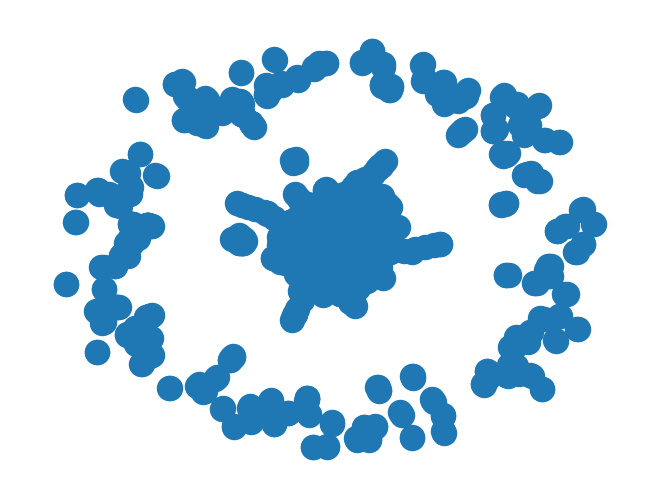

In [10]:
networkx.draw(G)

Select the biggest component (as the others have at most a couple dozen nodes) and view.

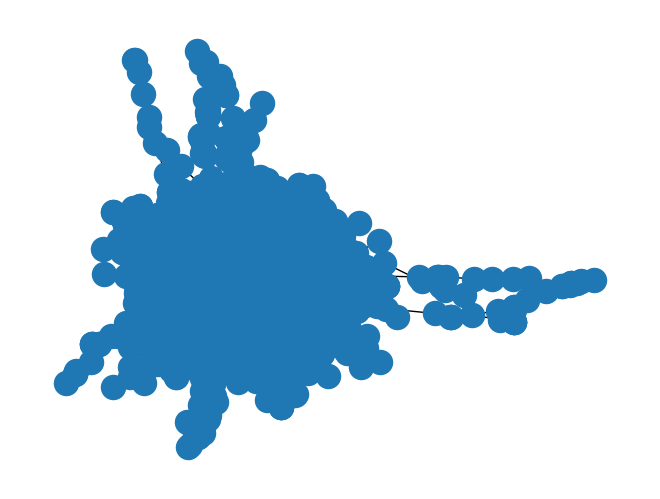

In [13]:
networkx.draw(Gcomponents[0])

# Constructing the Knowledge Graph Embedding

In [6]:
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory

Use train/test and validation splits for early stopping

In [7]:
path2Data = f"{data_dir}/dINT_simpl.tsv"

tf = TriplesFactory.from_path(path2Data)
tf

TriplesFactory(num_entities=16232, num_relations=2, create_inverse_triples=False, num_triples=439023, path="/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data/dINT_simpl.tsv")

In [8]:
print(tf.mapped_triples)
print(tf.mapped_triples.numpy().shape)
print(len(tf.entity_id_to_label))
# tf.entity_id_to_label

tensor([[    0,     0,  1942],
        [    0,     0,  1947],
        [    0,     0,  1992],
        ...,
        [16231,     0, 16228],
        [16231,     0, 16229],
        [16231,     0, 16230]])
(439023, 3)
16232


In [9]:
for k,v in tf.entity_id_to_label.items():
    if v == "0610009B22Rik":
        print(k)

1


Saving the entity2label object produced by TriplesFactory

In [10]:
import json

with open(f"{data_dir}/entityIDS.json","w") as outf:
    json.dump(tf.entity_id_to_label, outf)

## Compute model
Use defaults and 50 dimensional embedding spaces

In [11]:
modelKGE = "one50_unstratified_stopped_transe_GPU"

In [12]:
%%time

training, testing, validation = tf.split([.8, .1, .1])

result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model="TransE",
    model_kwargs=dict(embedding_dim=50),
    training_loop='sLCWA',
    negative_sampler='basic',
    stopper="early",
    random_seed=42,
    epochs=10,  # short epochs for testing - you should go
                # higher, especially with early stopper enabled
                
)

# result.save_to_directory(f"{kge_dir}/one50_unstratified_stopped_transe")
result.save_to_directory(f"{kge_dir}/{modelKGE}")

using automatically assigned random_state=181631285


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/1372 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=2048.
INFO:pykeen.evaluation.evaluator:Evaluation took 10.44s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 10: 0.3533585404186502. Saved model weights to /home/fc489/.data/pykeen/checkpoints/best-model-weights-8f763724-9cd4-4046-93d5-7e26a19ad1e0.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 10.


Evaluating on cuda:0:   0%|          | 0.00/43.9k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 11.37s seconds
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=16232, num_relations=2, create_inverse_triples=False, num_triples=351218, path="/gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/data/dINT_simpl.tsv") to file:///gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/KGEs/one50_unstratified_stopped_transe_GPU/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///gpfs/ysm/project/krishnaswamy_smita/fc489/yaleCollab/KGEs/one50_unstratified_stopped_transe_GPU


CPU times: user 5min 46s, sys: 4min 31s, total: 10min 17s
Wall time: 2min 42s


Running the above on CPU (iMac) takes between 12 to 14 minutes of compute time.
Running on CUDA cores takes 10 seconds per epoch, for a total of 2 mins 37s.


TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(16232, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2, 50)
    )
  )
  (weight_regularizers): ModuleList()
)


<AxesSubplot:title={'center':'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

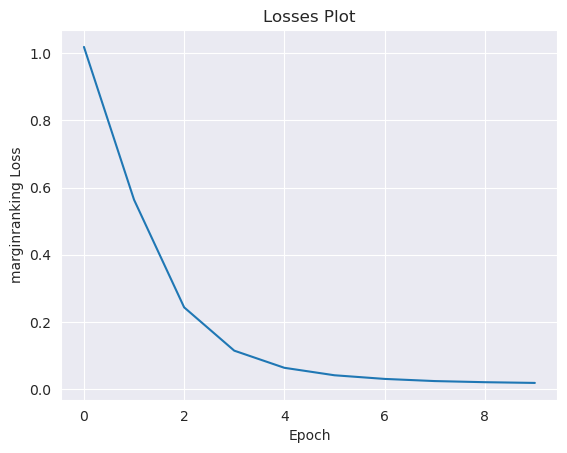

In [13]:
#model used TransE has only one representation for entities and relations, 
# so modules objects will be of length 1
print(result.model)
result.plot_losses()
# result.plot_early_stopping()

In [14]:
from typing import List
import pykeen.nn

entity_representation_modules: List['pykeen.nn.Representation'] = result.model.entity_representations
relation_representation_modules: List['pykeen.nn.Representation'] = result.model.relation_representations

In [15]:
entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

In [16]:
print(entity_embeddings)
print(relation_embeddings)

Embedding(
  (_embeddings): Embedding(16232, 50)
)
Embedding(
  (_embeddings): Embedding(2, 50)
)


In [17]:
#Access embeddings by index (default arg returns all)
entity_embedding_tensor: torch.FloatTensor = entity_embeddings(indices=None)
relation_embedding_tensor: torch.FloatTensor = relation_embeddings(indices=None)

In [18]:
entcount = 0
for i in entity_embedding_tensor:
    entcount+=1
print(f"We have {entcount} entities embedded on {len(i)} dimensions")

relcount = 0
for i in relation_embedding_tensor:
    relcount+=1
print(f"We have {relcount} relations embedded on {len(i)} dimensions")

We have 16232 entities embedded on 50 dimensions
We have 2 relations embedded on 50 dimensions


I don't understand why we have 3 types of relations, when the input data should only have 2!:

* FIXED!: THis was happening because I forgot to rmv the header....

In [ ]:
dINT["relation"].unique()

array(['LRinteraction', 'FIstring'], dtype=object)

Model should have been saved within one50... dir.
For future uses during development,  reload this default model. Later on, once we have added our own data or if prelim results are unsatisfactory, optimize methods and hyperparam.

# DR, clustering and visualisation

Now that we have a 50D KGE representing our data we can apply DR to generate a 2D space on which to visualise the entitites/nodes.

> From [pykeen docs](https://pykeen.readthedocs.io/en/stable/tutorial/translational_toy_example.html)

>*There was a lot of interesting follow-up discussion at !99 during which this code was implemented for re-use. One of the interesting points is that the relation plot is only applicable for translational distance models like TransE. Further, when models whose embeddings are higher than 2, a dimensionality reduction method must be used. For this, one of many of the tools from scikit-learn can be chosen. However, to make sure that the entities and relations are projected on the same axis, the dimensionality reduction model is first trained on the entity embeddings, then applied on both the entity embeddings and relation embeddings. Further, non-linear models like KPCA should not be used when plotting relations, since these _should_ correspond to linear transformations in embedding space.*

Furthermore, we should be able to cluster them and colour by cluster too. Hopefully there should be some overlap btwn the unsupervised clusters and pathway (biological/functional) annotations

## Prep

In [19]:
trained_model = torch.load(f"{kge_dir}/{modelKGE}/trained_model.pkl")
trained_model

TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(16232, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(2, 50)
    )
  )
  (weight_regularizers): ModuleList()
)

In [20]:
#Construct nodes dataframe: detach() for now is meaningless as compute is CPU

entity_embeddings = trained_model.entity_representations[0](indices=None).detach().cpu().numpy()
entity_embeddings

array([[-0.12969269,  0.23883933,  0.0298379 , ..., -0.23565318,
        -0.19836189, -0.04331296],
       [-0.01538737, -0.07859276, -0.03736909, ..., -0.0573249 ,
        -0.15588471, -0.12565903],
       [-0.07555951, -0.00453089, -0.01341537, ...,  0.00835948,
         0.09687331, -0.08575794],
       ...,
       [ 0.25191694,  0.02319024,  0.15396824, ..., -0.04534798,
         0.16958809,  0.19173549],
       [ 0.0273593 , -0.0359864 ,  0.17197928, ..., -0.00145774,
         0.26383528,  0.0853122 ],
       [ 0.129465  , -0.04223109,  0.11786426, ..., -0.0824331 ,
         0.2132709 ,  0.10344668]], dtype=float32)

To access a map of entities and relations to ID we must use the dictionary derived from the TriplesFactory step.

In [21]:
import json

with open(f"{data_dir}/entityIDS.json") as infile:
    entityIDS = json.load(infile)

# entityIDS

In [22]:
dKGE_50 = pd.DataFrame(entity_embeddings, index=entityIDS.values())
dKGE_50

0         1         2         3         4         5   \
              -0.129693  0.238839  0.029838  0.006323  0.005612 -0.144639   
0610009B22Rik -0.015387 -0.078593 -0.037369 -0.134775 -0.152775 -0.184697   
0610010K14Rik -0.075560 -0.004531 -0.013415 -0.197083 -0.132863 -0.168790   
0610040J01Rik  0.008109 -0.196191 -0.113744 -0.004154  0.166942  0.075061   
1110004F10Rik -0.147842  0.150598  0.016282  0.005736 -0.088667 -0.026258   
...                 ...       ...       ...       ...       ...       ...   
mt-Nd3         0.136801  0.093483 -0.038484  0.252373 -0.236669  0.175114   
mt-Nd4        -0.170447  0.012936 -0.106866  0.256636 -0.297928  0.258242   
mt-Nd4l        0.251917  0.023190  0.153968  0.244361 -0.208346  0.216257   
mt-Nd5         0.027359 -0.035986  0.171979  0.265450 -0.292502  0.198055   
mt-Nd6         0.129465 -0.042231  0.117864  0.261342 -0.272061  0.178837   

                     6         7         8         9   ...        40  \
              -0.023734  0.218808 -0.230301  0.166336  ... -0.090107   
0610009B22Rik  0.219734  0.155093 -0.144161 -0.041023  ... -0.249023   
0610010K14Rik -0.007698 -0.265014  0.297308 -0.004412  ...  0.114414   
0610040J01Rik -0.180401 -0.179722  0.028824 -0.013859  ...  0.202202   
1110004F10Rik -0.133562 -0.027705  0.140436 -0.147575  ... -0.100846   
...                 ...       ...       ...       ...  ...       ...   
mt-Nd3         0.006932 -0.048324  0.085212  0.132108  ...  0.126366   
mt-Nd4         0.023452  0.015826 -0.034891  0.213552  ...  0.161707   
mt-Nd4l        0.111636 -0.043303 -0.041972  0.221893  ...  0.004960   
mt-Nd5         0.098177 -0.093629  0.043694  0.063673  ...  0.055783   
mt-Nd6         0.122011 -0.248883  0.080525  0.225636  ... -0.066207   

                     41        42        43        44        45        46  \
               0.096736 -0.180720 -0.025639 -0.021463  0.062226 -0.129982   
0610009B22Rik  0.124448 -0.142202 -0.087347 -0.038815 -0.121407  0.190927   
0610010K14Rik  0.002237 -0.141460 -0.021869  0.007162  0.096029 -0.208771   
0610040J01Rik  0.147252 -0.109229 -0.113041  0.203763  0.249750  0.106485   
1110004F10Rik -0.037146  0.159978 -0.181098  0.073597 -0.230735 -0.175015   
...                 ...       ...       ...       ...       ...       ...   
mt-Nd3        -0.177334  0.097993  0.157976 -0.045268  0.006400 -0.084439   
mt-Nd4        -0.032312  0.070994  0.219350 -0.010851  0.040680 -0.013698   
mt-Nd4l        0.011897  0.144312  0.221798 -0.183956 -0.030106  0.064579   
mt-Nd5        -0.051918  0.212209  0.240778  0.091949  0.045859 -0.079121   
mt-Nd6         0.006559 -0.047389  0.211768  0.119474  0.005499 -0.138258   

                     47        48        49  
              -0.235653 -0.198362 -0.043313  
0610009B22Rik -0.057325 -0.155885 -0.125659  
0610010K14Rik  0.008359  0.096873 -0.085758  
0610040J01Rik -0.262336 -0.228321  0.161035  
1110004F10Rik -0.156508  0.155243 -0.116222  
...                 ...       ...       ...  
mt-Nd3         0.122818  0.235439  0.105841  
mt-Nd4         0.095304  0.170496  0.022967  
mt-Nd4l       -0.045348  0.169588  0.191735  
mt-Nd5        -0.001458  0.263835  0.085312  
mt-Nd6        -0.082433  0.213271  0.103447  

[16232 rows x 50 columns]

## Compute PCA

Compute PCA and check %var explained by first 2 components.
Use them as prelim space on which to view scatter plot of gene/protein embeddings and then colour downstream by metadata (pathway info and clusters)

In [23]:
import scprep
from sklearn.decomposition import PCA

dKGE_RedDim = PCA(n_components=2).fit_transform(dKGE_50)
dKGE_RedDim = pd.DataFrame(dKGE_RedDim, index=entityIDS.values())
dKGE_RedDim.index.name = "GeneSymbol"
dKGE_RedDim

0         1
GeneSymbol                       
              -0.077118 -0.010973
0610009B22Rik -0.239292  0.011564
0610010K14Rik  0.129711  0.428279
0610040J01Rik -0.037997  0.067762
1110004F10Rik -0.232670  0.157353
...                 ...       ...
mt-Nd3         0.004741  0.333583
mt-Nd4         0.026099  0.336775
mt-Nd4l       -0.003956  0.088954
mt-Nd5        -0.142095  0.304162
mt-Nd6         0.115325  0.124947

[16232 rows x 2 columns]

## Clustering

In [26]:
print("Number of pathways in CellChatDB: ", len(pd.read_csv(f"{data_dir}/dINT.tsv", sep="\t")["pathway"].unique()))


Number of pathways in CellChatDB:  230


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ccmultiomkge/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3378: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Let's compute clusters labels for a set of K and see which one results in the best silhouette scores.

For n_clusters = 2 The average silhouette_score is : 0.029706646
For n_clusters = 3 The average silhouette_score is : 0.027842112
For n_clusters = 4 The average silhouette_score is : 0.02612431
For n_clusters = 5 The average silhouette_score is : 0.025938388
For n_clusters = 6 The average silhouette_score is : 0.025345987
For n_clusters = 8 The average silhouette_score is : 0.025449734


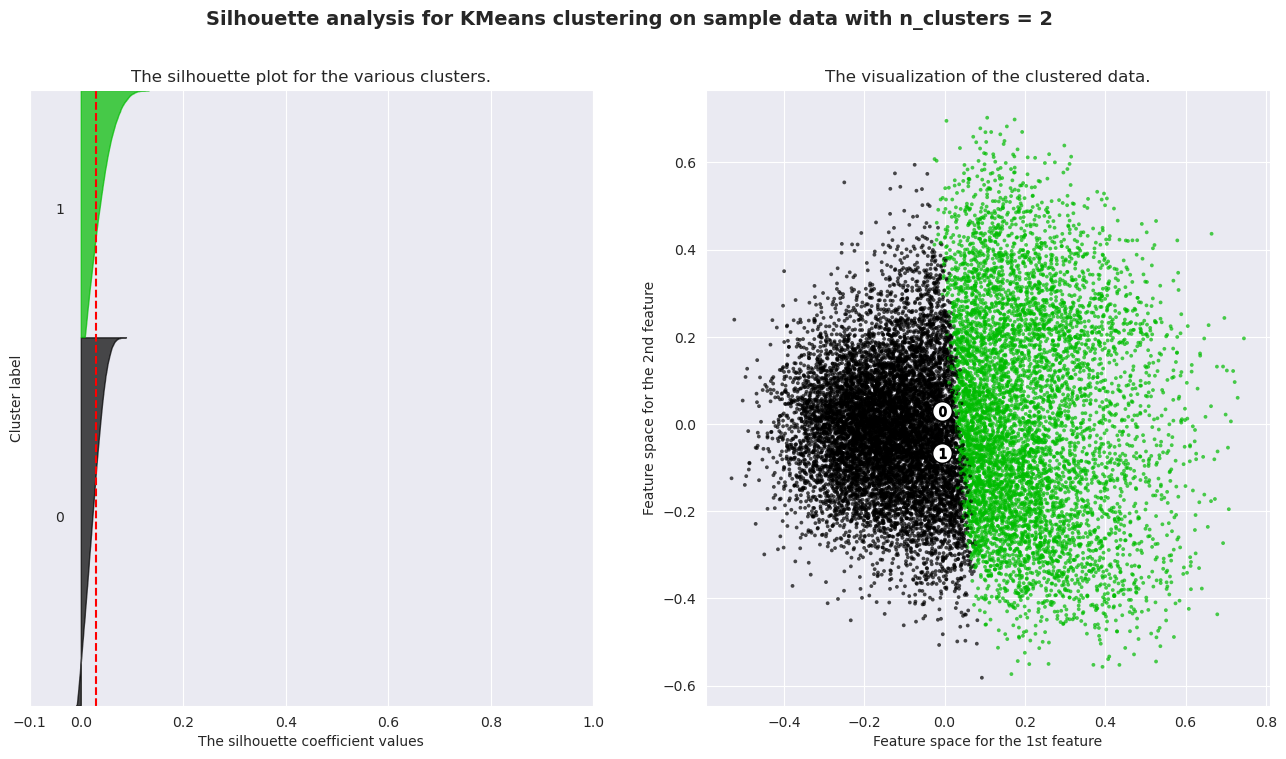

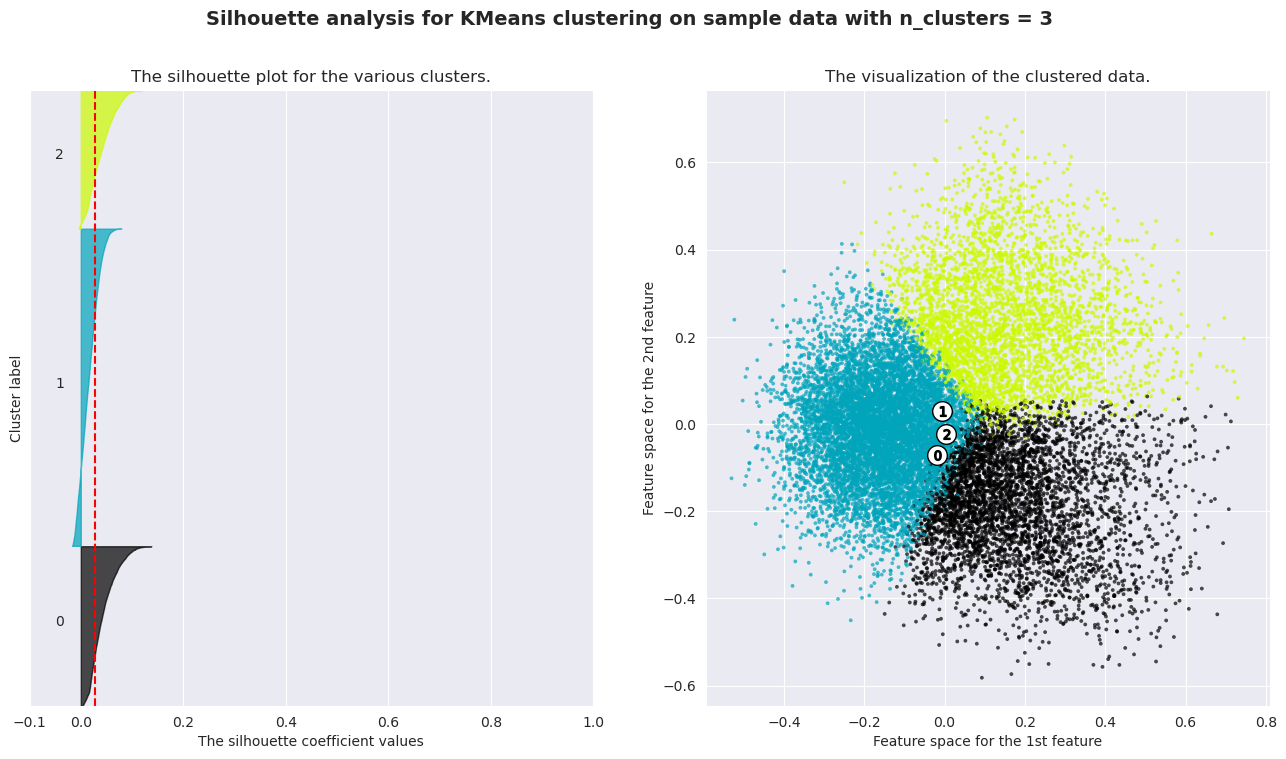

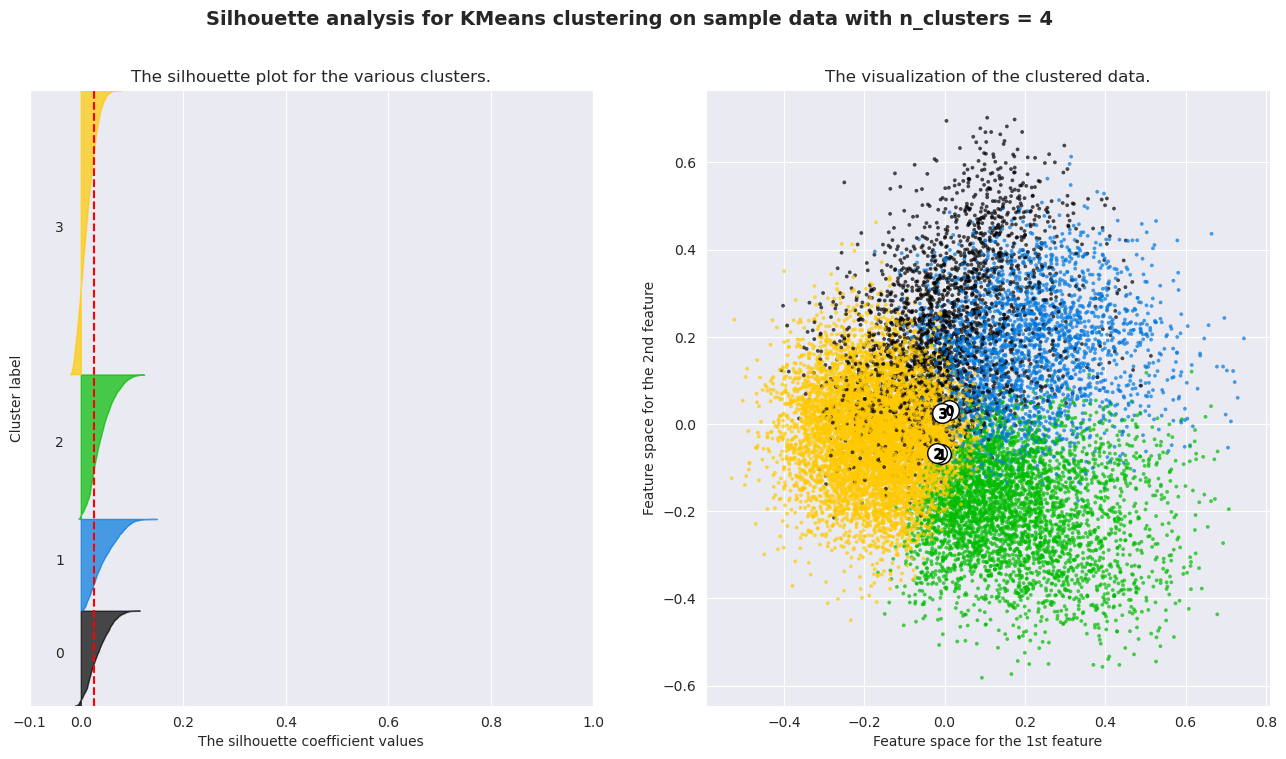

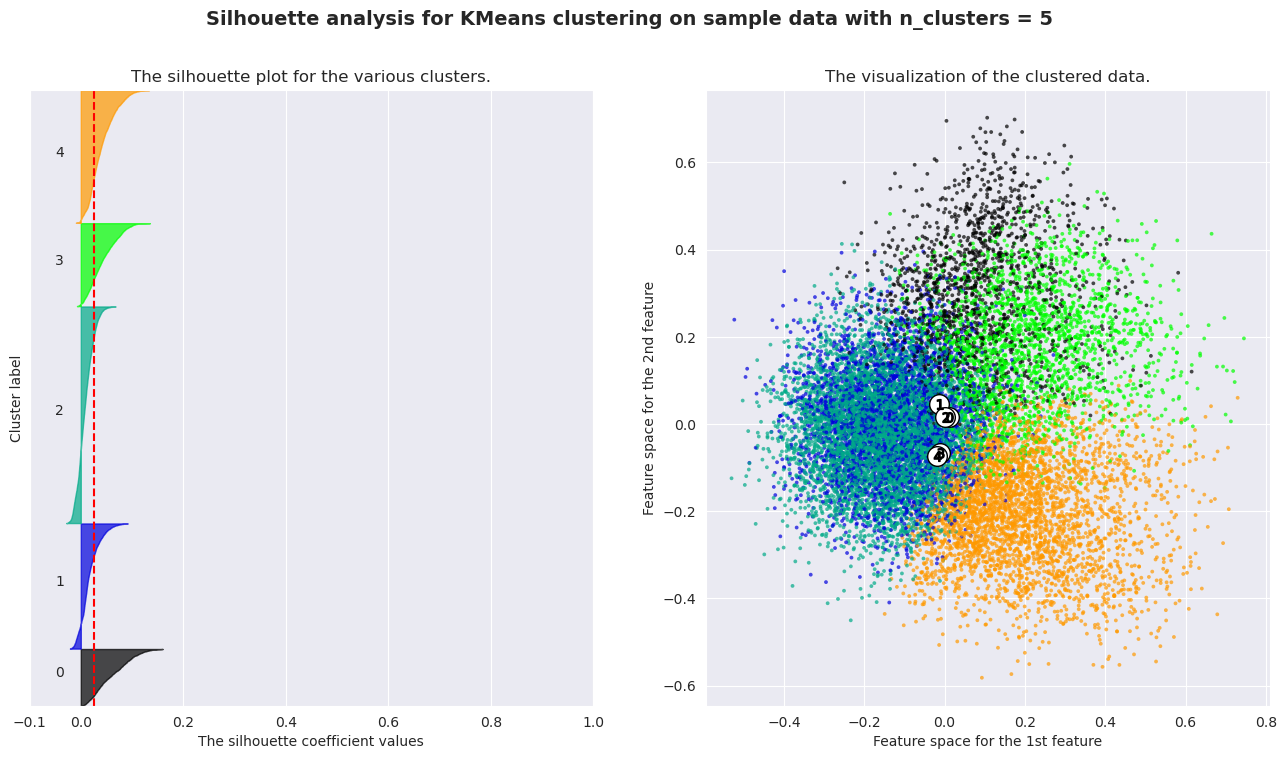

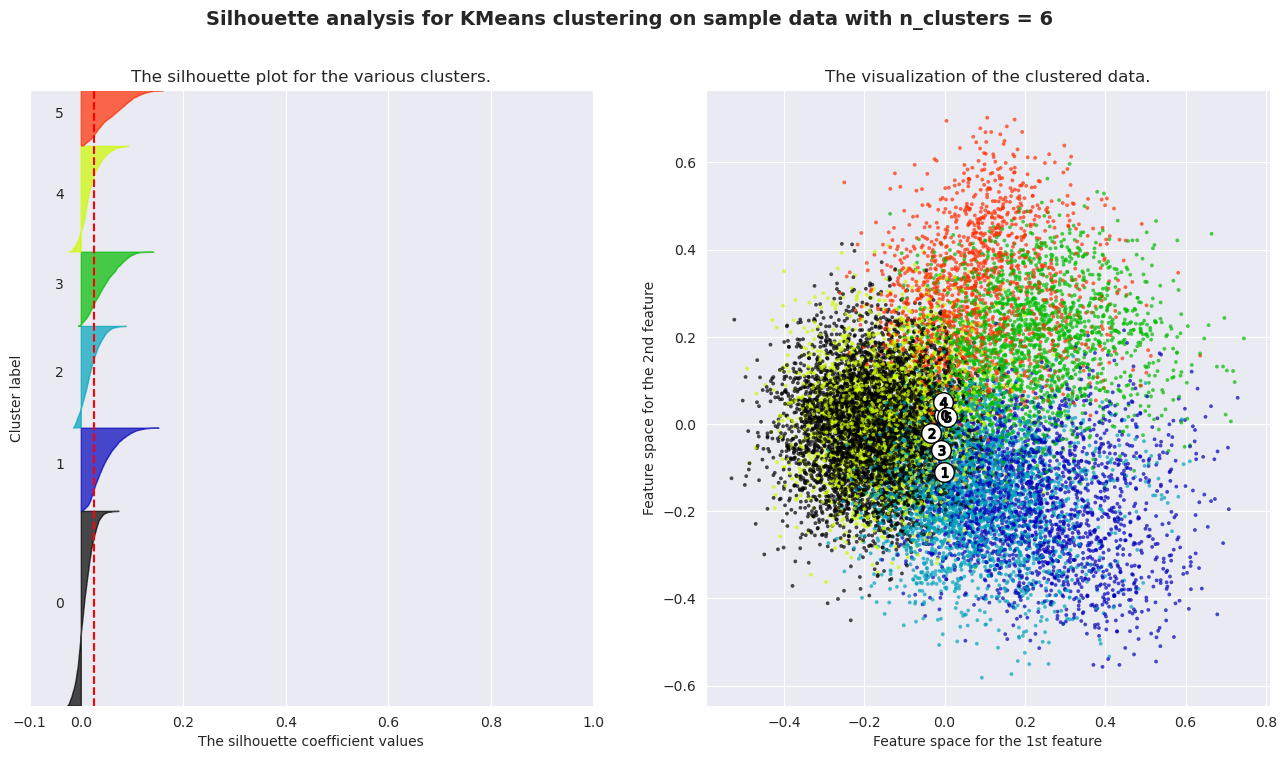

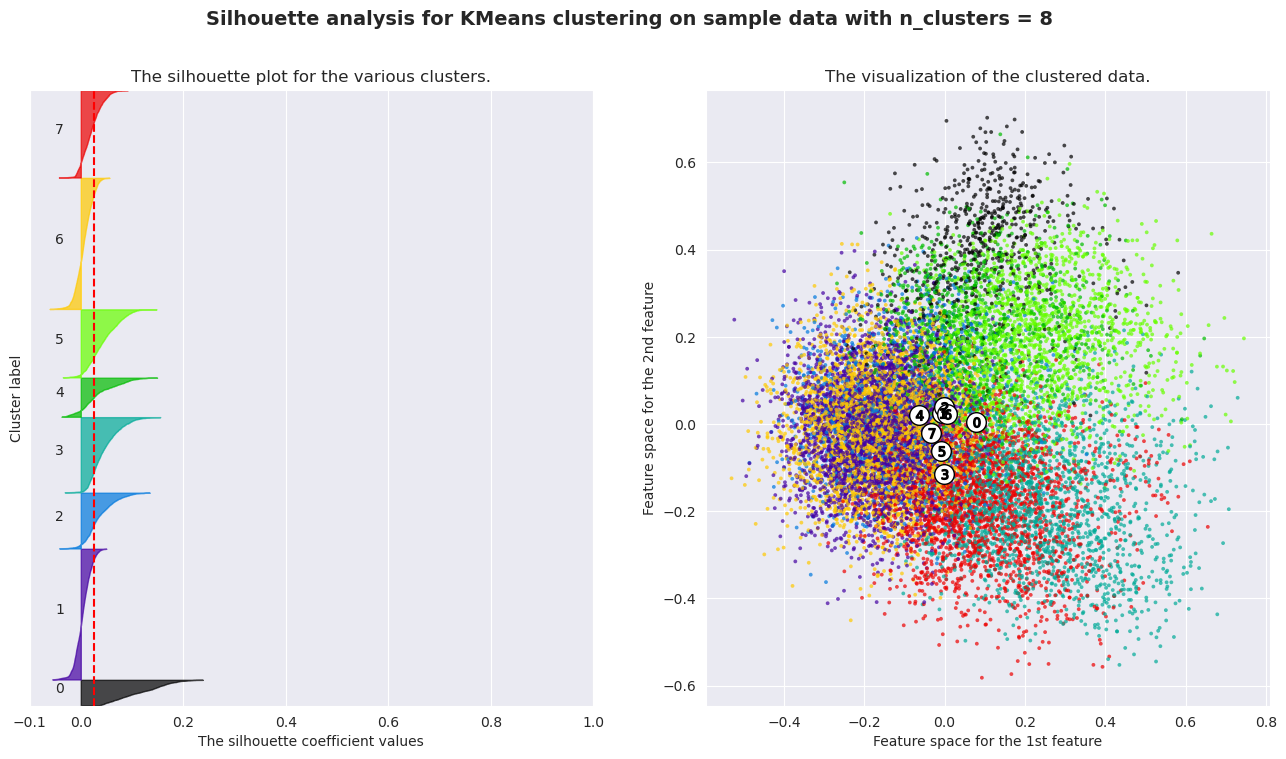

In [27]:
#Snippet from scikit-learn docs

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


#Remove NA from first missing genesymbol row in dKGE:
dKGE_50 = dKGE_50.dropna()
dKGE_RedDim = dKGE_RedDim.dropna()

range_clust = [2,3,4,5,6,8]

for n_clusters in range_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(16, 8)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 
    # # but in this example all
    # # lie within [-0.1, 1]
    # ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dKGE_50) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 12 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=12)
    cluster_labels = clusterer.fit_predict(dKGE_50)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dKGE_50, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dKGE_50, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        dKGE_RedDim[0], dKGE_RedDim[1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


Let's use k=4 for now. AVG silhouette scores are kind of abysmal and similar for 
all K (including the previous k=12)

In [28]:
clusters = KMeans(n_clusters=4, random_state=12).fit_predict(dKGE_50)
#Append cluster column to RD dataframe.
dKGE_RedDim.insert(len(dKGE_RedDim.columns), "clust", clusters)
dKGE_RedDim

0         1  clust
GeneSymbol                              
              -0.077118 -0.010973      3
0610009B22Rik -0.239292  0.011564      3
0610010K14Rik  0.129711  0.428279      1
0610040J01Rik -0.037997  0.067762      3
1110004F10Rik -0.232670  0.157353      3
...                 ...       ...    ...
mt-Nd3         0.004741  0.333583      0
mt-Nd4         0.026099  0.336775      0
mt-Nd4l       -0.003956  0.088954      0
mt-Nd5        -0.142095  0.304162      0
mt-Nd6         0.115325  0.124947      0

[16232 rows x 3 columns]

## Pathway metadata annotation

Get pathway info via REACTOME database (WIP)

- ReactomePathways DB has 2 columns, one for the pathway ID and another for the string name:
    - `curl -o ReactomePathways.txt https://reactome.org/download/current/ReactomePathways.txt`
<!-- - Ewas2Pathway DB links reactome protein/PTM ID with 2 pathway ID, lowest and higher level. -->
- ENSEMBL2Reactmoe DB can be used to link ENSEMBL with reactome pathways
    - `curl -o Ensembl2Reactome.txt https://reactome.org/download/current/Ensembl2Reactome.txt`
    - `curl -o Ensembl2Reactome_ALL.txt https://reactome.org/download/current/Ensembl2Reactome_All_Levels.txt`

Notes:
Future application could use Reactome IDS, for gene Symbols can be trivially converted and ENSP ID can also be converted from STRINGs or REACTOME's own Functional Interaction network DBS -> Need to pick the baseline EWAS ID for a non PTMd/modified entity. 

Also nOte that ideally Antibodies from a cytof panel woud need to be fuzzy matched against Reactome EWAS names to get a REactome ID specific to a certain PTM. OTherwise, use ENSP ID to ReactomeEWAS

In [33]:
from biomart import BiomartServer


#Load reactome database
dENSMUSpathwayR = pd.read_csv(f"{data_dir}/DBs/Ensembl2Reactome.txt", sep="\t", header=None)
dENSMUSpathwayR = dENSMUSpathwayR.loc[dENSMUSpathwayR[5]=="Mus musculus"]
#Number of pathways
print(len(dENSMUSpathwayR[1].unique()))
print(len(dENSMUSpathwayR[3].unique()))

#Biomart
server = BiomartServer("http://useast.ensembl.org/biomart")
server.verbose = True

mart = server.datasets["mmusculus_gene_ensembl"]

response = mart.search({"attributes":["ensembl_peptide_id","mgi_symbol"]})

transDF = []

for line in response.raw.data.decode("utf-8").splitlines():
    line = line.split("\t")
    if len(line[0]) > 0: #Only get gene symbols with ENSP ID
        transDF.append(line)

transDF = pd.DataFrame(transDF, 
                columns=["ensembl_peptide_id","mgi_symbol"]
                ).drop_duplicates()

transDict = transDF.set_index("ensembl_peptide_id"
                ).to_dict(
                    #Transform DF into a dictionary but first set index
                )["mgi_symbol"]#Nested dict, so get first (and only item)
transDict

dENSMUSpathwayR[0] = dENSMUSpathwayR[0].map(transDict)
dENSMUSpathwayR.dropna(inplace=True)

#We have lost "only" 3 pathways from ENSP to geneSymbol missmatches
print(len(dENSMUSpathwayR[1].unique()))

#Turn into dictionary for mapping:
dENSMUSpathwayR = pd.DataFrame(dENSMUSpathwayR, 
                columns=[0,3]
                ).drop_duplicates()
print(dENSMUSpathwayR)



1360
1360
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching datasets
[BiomartServer:'http://useast.ensembl.org/biomart/martservice'] Fetching databases
[BiomartDatabase:'Ensembl Genes 107'] Fetching datasets
[BiomartDatabase:'Mouse strains 107'] Fetching datasets
[BiomartDatabase:'Sequence'] Fetching datasets
[BiomartDatabase:'Ontology'] Fetching datasets
[BiomartDatabase:'Genomic features 107'] Fetching datasets
[BiomartDatabase:'Ensembl Variation 107'] Fetching datasets
[BiomartDatabase:'Ensembl Regulation 107'] Fetching datasets
[BiomartDataset:'mmusculus_gene_ensembl'] Searching using following params:
{'attributes': ['ensembl_peptide_id', 'mgi_symbol']}
[BiomartDataset:'mmusculus_gene_ensembl'] Fetching attributes
[BiomartDataset] search query:
b'<Query virtualSchemaName="default" formatter="TSV" header="0" uniqueRows="1" datasetConfigVersion="0.6" count=""><Dataset name="mmusculus_gene_ensembl" interface="default"><Attribute name="ensembl_peptide_id" /><Att

Dictionary that links a GeneSymbol with (lowest level) pathways from Reactome

In [34]:
dPathwayDict = {}

for i in dENSMUSpathwayR.iterrows():
    gene = i[1][0]
    pathway = i[1][3]
    if gene not in dPathwayDict.keys():
        dPathwayDict[gene] = []
    dPathwayDict[gene].append(pathway)

print(dPathwayDict["Gnai3"])
print(dPathwayDict[gene])

['Adenylate cyclase inhibitory pathway', 'ADP signalling through P2Y purinoceptor 12', 'G alpha (i) signalling events', 'Extra-nuclear estrogen signaling']
['PRC2 methylates histones and DNA', 'Condensation of Prophase Chromosomes', 'HATs acetylate histones', 'Recruitment and ATM-mediated phosphorylation of repair and signaling proteins at DNA double strand breaks', 'Nonhomologous End-Joining (NHEJ)', 'Processing of DNA double-strand break ends', 'Deposition of new CENPA-containing nucleosomes at the centromere', 'G2/M DNA damage checkpoint', 'RUNX1 regulates genes involved in megakaryocyte differentiation and platelet function', 'Estrogen-dependent gene expression']


In [35]:
dKGE_RedDim["pathway"] = dKGE_RedDim.index.map(dPathwayDict)
dKGE_RedDim

0         1  clust  \
GeneSymbol                                 
              -0.077118 -0.010973      3   
0610009B22Rik -0.239292  0.011564      3   
0610010K14Rik  0.129711  0.428279      1   
0610040J01Rik -0.037997  0.067762      3   
1110004F10Rik -0.232670  0.157353      3   
...                 ...       ...    ...   
mt-Nd3         0.004741  0.333583      0   
mt-Nd4         0.026099  0.336775      0   
mt-Nd4l       -0.003956  0.088954      0   
mt-Nd5        -0.142095  0.304162      0   
mt-Nd6         0.115325  0.124947      0   

                                                         pathway  
GeneSymbol                                                        
                                                             NaN  
0610009B22Rik                                                NaN  
0610010K14Rik                                                NaN  
0610040J01Rik                                                NaN  
1110004F10Rik                                                NaN  
...                                                          ...  
mt-Nd3         [Respiratory electron transport, Complex I bio...  
mt-Nd4         [Respiratory electron transport, Complex I bio...  
mt-Nd4l                                                      NaN  
mt-Nd5         [Respiratory electron transport, Complex I bio...  
mt-Nd6         [Respiratory electron transport, Complex I bio...  

[16232 rows x 4 columns]

**FUTURE?** 
Use instead higher level pathawys, for lower level results in over 1k pathways (and we just need a proof of concept that it is working)

In [ ]:
# dENSMUSpathwayR = pd.read_csv("Ensembl2Reactome_ALL.txt", sep="\t", header=None)
# dENSMUSpathwayR = dENSMUSpathwayR.loc[dENSMUSpathwayR[5]=="Mus musculus"]
# dENSMUSpathwayR

## Viz

### Clusters

<AxesSubplot:title={'center':'Clusters'}, xlabel='PC-1', ylabel='PC-2'>

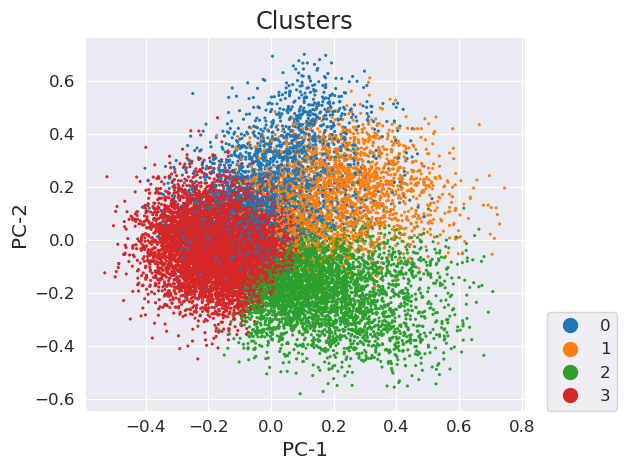

In [36]:
scprep.plot.scatter2d(dKGE_RedDim, c=dKGE_RedDim["clust"], 
    title="Clusters", label_prefix="PC-", 
    legend_loc=(1.05, 0), shuffle=True,
    dpi=480)

DONE: ~~View silhouette scores of current k=12 clusters (in the future. actully use scores to decide on k as shown in
[Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html?highlight=silhouette))~~

In [37]:
from sklearn.metrics import silhouette_samples, silhouette_score

#We are suing the 50D embedding space. Given our awful k selection, we end up 
# with a very low silhouette avergae. If computing distances on PCA space, 
# the silhouette score even becomes negative lol

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
silhouette_avg = silhouette_score(dKGE_50, dKGE_RedDim[["clust"]])
print(
    "For n_clusters =",
    len(dKGE_RedDim["clust"].unique()),
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(dKGE_50, dKGE_RedDim[["clust"]])
print(sample_silhouette_values)

/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ccmultiomkge/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


For n_clusters = 4 The average silhouette_score is : 0.02612431


/gpfs/ysm/project/krishnaswamy_smita/fc489/conda_envs/ccmultiomkge/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[-0.0040356   0.02253127  0.0631983  ...  0.04590861  0.02800818
  0.03882089]


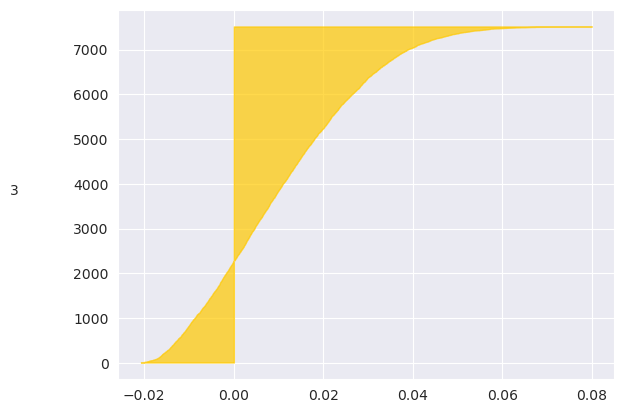

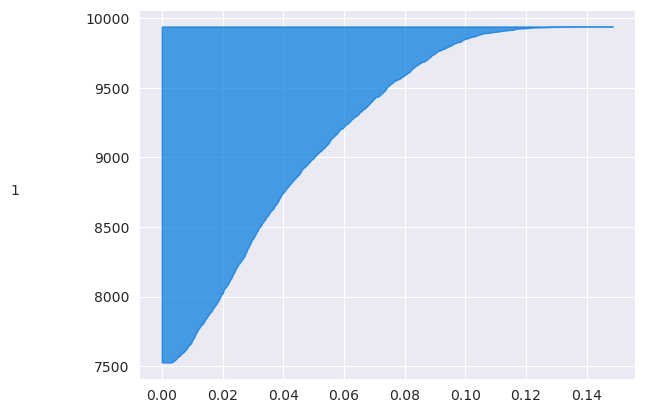

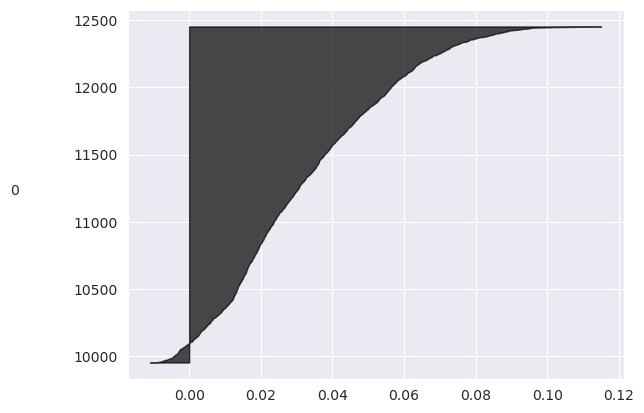

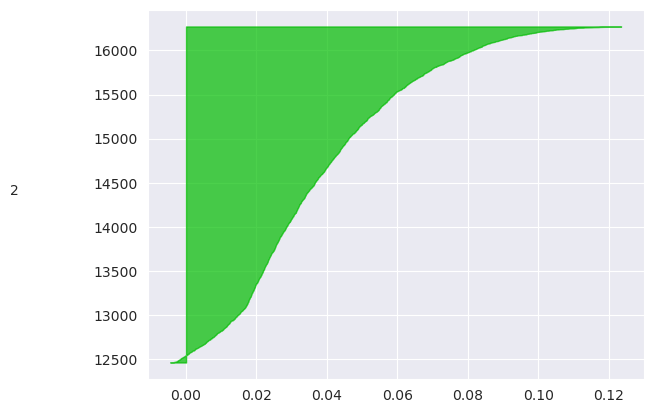

In [38]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

y_lower = 10
for i in dKGE_RedDim["clust"].unique():
    fig, ax = plt.subplots()
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[dKGE_RedDim["clust"] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / len(dKGE_RedDim["clust"].unique()))
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples



NOTE: It is abundantly clear that k=12 is far too high of a number ...

### Pathways

Single pathway "at random"

In [39]:
dKGE_RedDim = dKGE_RedDim.dropna()

pathwayOFinterest = "Respiratory electron transport"

dKGE_RedDim.loc[dKGE_RedDim["pathway"].apply(lambda x: pathwayOFinterest in x)]

hits = dKGE_RedDim.index.isin(dKGE_RedDim.loc[dKGE_RedDim["pathway"].apply(lambda x: pathwayOFinterest in x)].index)
hits

array([False, False, False, ...,  True,  True,  True])

<AxesSubplot:xlabel='PC-1', ylabel='PC-2'>

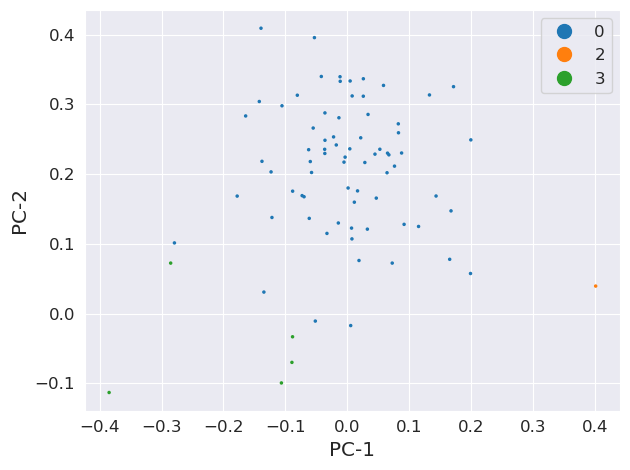

In [40]:
scprep.plot.scatter2d(dKGE_RedDim,
    c=dKGE_RedDim["clust"],
    mask=hits, 
    label_prefix="PC-", shuffle=True)

Biggest pathways

In [42]:
dKGE_RedDim.dropna()["pathway"].explode().to_frame()

pathway
GeneSymbol                                    
2310057N15Rik                   Keratinization
9130019O22Rik    Generic Transcription Pathway
A1bg                   Platelet degranulation 
A1bg                  Neutrophil degranulation
A1cf           mRNA Editing: C to U Conversion
...                                        ...
mt-Nd4                    Complex I biogenesis
mt-Nd5          Respiratory electron transport
mt-Nd5                    Complex I biogenesis
mt-Nd6          Respiratory electron transport
mt-Nd6                    Complex I biogenesis

[26674 rows x 1 columns]

In [43]:
# #Old method where only one pathway is linked with a gene
# dKGE_RedDim.groupby(["pathway"]).size().reset_index(name="counts").sort_values(by=["counts"], ascending=False)

#Current approach with pathway lists
# dKGE_RedDim["pathway"].explode()

import ast

#On iMac, ast.literal_eval needed to make pathway column into actual lists, so that we can use series.explode() -> 
    #explore why this could be happening
# dKGE_pathways = dKGE_RedDim.dropna()["pathway"].apply(ast.literal_eval).explode().to_frame()
dKGE_pathways = dKGE_RedDim.dropna()["pathway"].explode().to_frame()
dKGE_pathways = dKGE_pathways.groupby(["pathway"]).size().reset_index(name="counts").sort_values(
    by=["counts"], ascending=False)
dKGE_pathways

pathway  counts
727                            Neutrophil degranulation     467
95    Antigen processing: Ubiquitination & Proteasom...     271
705                                         Neddylation     212
419                       G alpha (i) signalling events     209
1089                    Separation of Sister Chromatids     176
...                                                 ...     ...
1319                                          Vitamin E       1
1093        Serotonin clearance from the synaptic cleft       1
743                               Nucleotide catabolism       1
322   EGR2 and SOX10-mediated initiation of Schwann ...       1
677   MyD88:MAL(TIRAP) cascade initiated on plasma m...       1

[1354 rows x 2 columns]

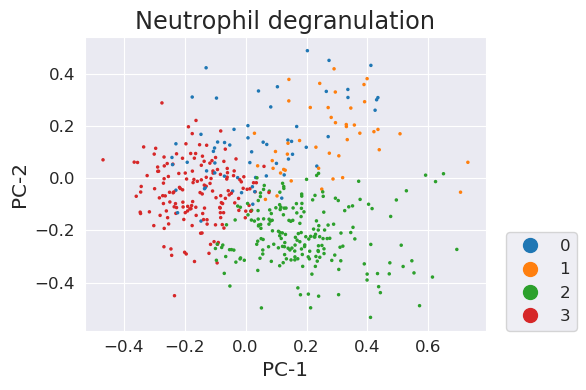

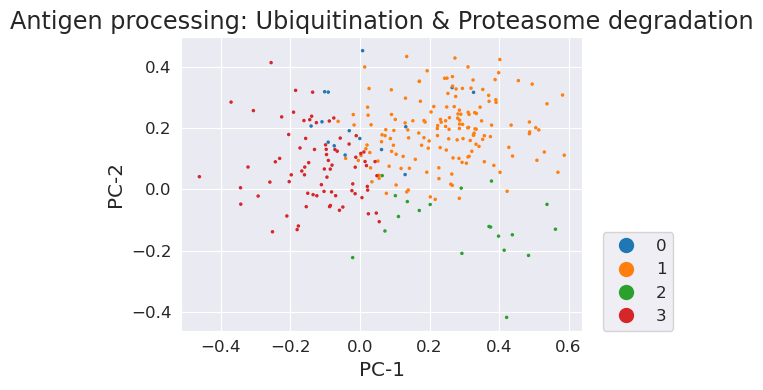

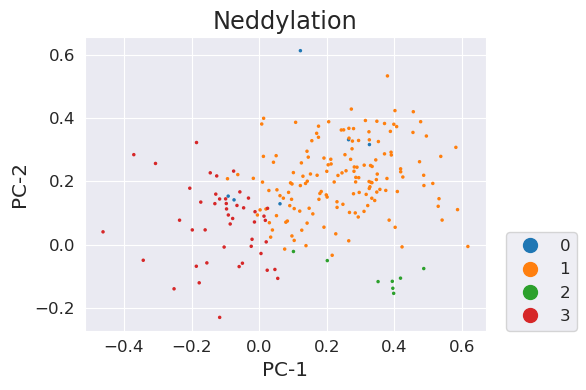

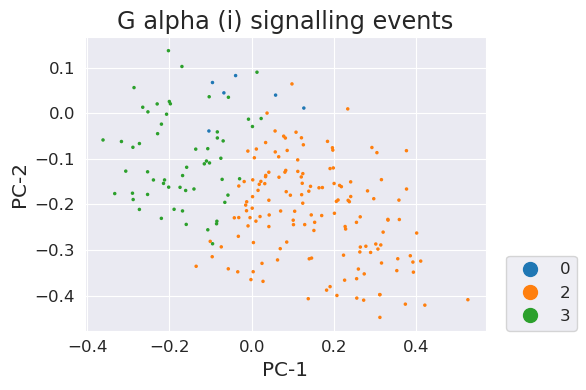

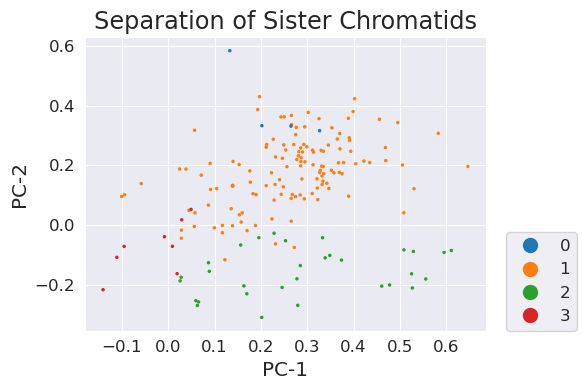

In [44]:
dKGE_RedDim = dKGE_RedDim.dropna()

for i in dKGE_pathways.nlargest(5, "counts")["pathway"]:
    hits = dKGE_RedDim.index.isin(dKGE_RedDim.loc[dKGE_RedDim["pathway"].apply(lambda x: i in x)].index)
    scprep.plot.scatter2d(dKGE_RedDim,
        c=dKGE_RedDim["clust"],
        mask=hits, 
        title = i, label_prefix="PC-", 
        legend_loc=(1.05, 0), shuffle=True,
        dpi=480, figsize=(6,4))

#### Deprecated approach

Silhoutte scores of pathways:
Dirty approach just ot compute AVG silhouette score for all of them.
Also take the top 5 above and compute their silhouette sample scores.

THis used to work when we had only one pathway associated with a single gene. Now however a single gene can belong to multiple pahtways, making silhouette computation impossible impossibly with the current annotation system.
Pathways then will have to essentially be OHE so that we can look a single pathaway agains the rest of genes not linked to it.
An alternative to this that perhaps we should keep in mind would be to use treat pathways as their own type of nodes, and record gene/protein belonging via belongs_to edges.

[DEPRECATED] ALL PATHWAYS

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from sklearn.metrics import silhouette_samples, silhouette_score

# #We are suing the 50D embedding space. Given our awful k selection, we end up 
# # with a very low silhouette avergae. If computing distances on PCA space, 
# # the silhouette score even becomes negative lol

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters

# df2 = RDdataframe.dropna()
# df1 = testdf.loc[testdf.index.isin(df2.index)]

# silhouette_avg = silhouette_score(df1, df2[["pathway"]])
# print(
#     "For n_clusters =",
#     len(df2["pathway"].unique()),
#     "The average silhouette_score is :",
#     silhouette_avg,
# )

# # Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(df1, df2[["pathway"]])
# print(sample_silhouette_values)

# y_lower = 10
# counter = 0
# for i in top5pathways:
#     fig, ax = plt.subplots()
#     # Aggregate the silhouette scores for samples belonging to
#     # cluster i, and sort them
#     ith_cluster_silhouette_values = sample_silhouette_values[df2["pathway"] == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.nipy_spectral(float(counter) / len(top5pathways))
#     ax.fill_betweenx(
#         np.arange(y_lower, y_upper),
#         0,
#         ith_cluster_silhouette_values,
#         facecolor=color,
#         edgecolor=color,
#         alpha=0.7,
#     )

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples
#     counter+=1

[DEPRECATED] Subset to entities belonging to the top 5 pathways only

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# from sklearn.metrics import silhouette_samples, silhouette_score

# #We are suing the 50D embedding space. Given our awful k selection, we end up 
# # with a very low silhouette avergae. If computing distances on PCA space, 
# # the silhouette score even becomes negative lol

#     # The silhouette_score gives the average value for all the samples.
#     # This gives a perspective into the density and separation of the formed
#     # clusters

# df2 = RDdataframe.loc[RDdataframe["pathway"].isin(top5pathways)].dropna()
# df1 = testdf.loc[testdf.index.isin(df2.index)]

# silhouette_avg = silhouette_score(df1, df2[["pathway"]])
# print(
#     "For n_clusters =",
#     len(df2["pathway"].unique()),
#     "The average silhouette_score is :",
#     silhouette_avg,
# )

# # Compute the silhouette scores for each sample
# sample_silhouette_values = silhouette_samples(df1, df2[["pathway"]])
# print(sample_silhouette_values)

# y_lower = 10
# counter = 0
# for i in top5pathways:
#     fig, ax = plt.subplots()
#     # Aggregate the silhouette scores for samples belonging to
#     # cluster i, and sort them
#     ith_cluster_silhouette_values = sample_silhouette_values[df2["pathway"] == i]

#     ith_cluster_silhouette_values.sort()

#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i

#     color = cm.nipy_spectral(float(counter) / len(top5pathways))
#     ax.fill_betweenx(
#         np.arange(y_lower, y_upper),
#         0,
#         ith_cluster_silhouette_values,
#         facecolor=color,
#         edgecolor=color,
#         alpha=0.7,
#     )

#     # Label the silhouette plots with their cluster numbers at the middle
#     ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

#     # Compute the new y_lower for next plot
#     y_lower = y_upper + 10  # 10 for the 0 samples
#     counter+=1

[DEPRECATED] Now, this looks promisisng. Among the top pathways, we can see how the silhouette scores kind of match the patterns seen on the PCA embedding, where some pathways are clearly localised in a region of the space (and linked with a subset of clusters), while others seem to be dispersed throughout.
Biological signaficance of this should be somewhat easy to hypothesise on...

Single pathway approach:
This is feasible with the multiple genes/pathway data, as we can just build a label for silhouette computation that determines if a gene belongs or not to a particular pathway.

Do it for the top 5 pathways as found in the previous section.

In [45]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

# df2 = RDdataframe.dropna()
# df1 = testdf.loc[testdf.index.isin(df2.index)]

# silhouette_avg = silhouette_score(df1, df2[["pathway"]])
# print(
#     "For n_clusters =",
#     len(df2["pathway"].unique()),
#     "The average silhouette_score is :",
#     silhouette_avg,
# )
dKGE_RedDim = dKGE_RedDim.dropna()
df1 = dKGE_50.loc[dKGE_50.index.isin(dKGE_RedDim.index)]

for i in dKGE_pathways.nlargest(5, "counts")["pathway"]:
    print(i)
    df2 = dKGE_RedDim.index.isin(dKGE_RedDim.loc[dKGE_RedDim["pathway"].apply(lambda x: i in x)].index)
    silhouette_avg = silhouette_score(df1, df2)
    print(f"For {i} pathway",
    f"The average silhouette_score is {silhouette_avg}")


Neutrophil degranulation
For Neutrophil degranulation pathway The average silhouette_score is -0.00035591062624007463
Antigen processing: Ubiquitination & Proteasome degradation
For Antigen processing: Ubiquitination & Proteasome degradation pathway The average silhouette_score is 0.005433985032141209
Neddylation
For Neddylation pathway The average silhouette_score is 0.0048932344652712345
G alpha (i) signalling events
For G alpha (i) signalling events pathway The average silhouette_score is 4.421480116434395e-05
Separation of Sister Chromatids
For Separation of Sister Chromatids pathway The average silhouette_score is -0.001673874561674893


It might be an interasting thing to look into the pathways with the highest 
silhouette scores and see how those are distributed on the PC space.

## Save/Load metadata

In [46]:
dKGE_RedDim.to_csv(f"{kge_dir}/{modelKGE}/dKGE_RedDim.csv")

In [47]:
dKGE_RedDim = pd.read_csv(f"{kge_dir}/{modelKGE}/dKGE_RedDim.csv", index_col="GeneSymbol")
dKGE_RedDim

0         1  clust  \
GeneSymbol                                 
2310057N15Rik -0.233191  0.014282      3   
9130019O22Rik -0.194726  0.254901      3   
A1bg           0.223174 -0.195471      2   
A1cf          -0.270403  0.028372      3   
A2m            0.114908 -0.237813      2   
...                 ...       ...    ...   
mt-Nd2         0.072755  0.072423      0   
mt-Nd3         0.004741  0.333583      0   
mt-Nd4         0.026099  0.336775      0   
mt-Nd5        -0.142095  0.304162      0   
mt-Nd6         0.115325  0.124947      0   

                                                         pathway  
GeneSymbol                                                        
2310057N15Rik                                 ['Keratinization']  
9130019O22Rik                  ['Generic Transcription Pathway']  
A1bg           ['Platelet degranulation ', 'Neutrophil degran...  
A1cf           ['mRNA Editing: C to U Conversion', 'Formation...  
A2m            ['Platelet degranulation ', 'Intrinsic Pathway...  
...                                                          ...  
mt-Nd2         ['Respiratory electron transport', 'Complex I ...  
mt-Nd3         ['Respiratory electron transport', 'Complex I ...  
mt-Nd4         ['Respiratory electron transport', 'Complex I ...  
mt-Nd5         ['Respiratory electron transport', 'Complex I ...  
mt-Nd6         ['Respiratory electron transport', 'Complex I ...  

[7659 rows x 4 columns]